In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks, which is why we are using cv2_imshow instead

In [ ]:
model = InceptionV3(weights='imagenet')

model.summary()

96116736/96112376 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
!wget https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
!wget https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png


--2021-01-16 17:15:01--  https://indiasendangered.com/wp-content/uploads/2011/09/elephant.jpg
Resolving indiasendangered.com (indiasendangered.com)... 199.79.62.149
Connecting to indiasendangered.com (indiasendangered.com)|199.79.62.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137242 (134K) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>] 134.03K  --.-KB/s    in 0.1s    

2021-01-16 17:15:02 (1.23 MB/s) - ‘elephant.jpg’ saved [137242/137242]

--2021-01-16 17:15:02--  https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12234558/Chinook-On-White-03.jpg
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.41.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.41.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25761 (25K) [image/jpeg]
Saving to: ‘Chinook-On-White-03.jpg’

Chinook-On-White-03 100%[===================>]  25.16K  --.-KB/s    in 0.001s  

2021

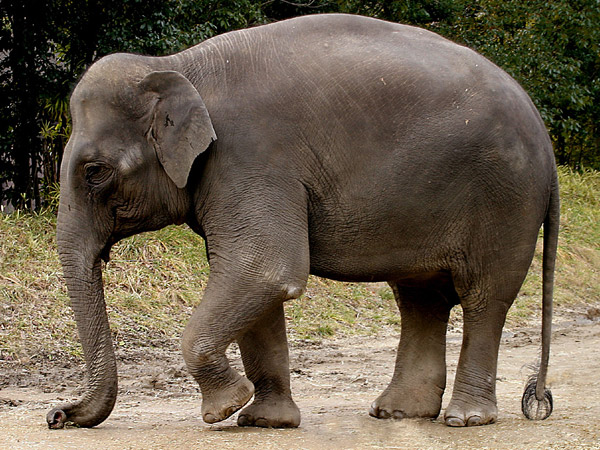

In [ ]:
ORIGINAL = 'elephant.jpg'

DIM = 299

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(ORIGINAL)) # Visualize image

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print(decode_predictions(preds))

40960/35363 [==================================] - 0s 0us/step
[[('n02504013', 'Indian_elephant', 0.96241), ('n01871265', 'tusker', 0.015191094), ('n02504458', 'African_elephant', 0.00047370253), ('n04346328', 'stupa', 0.00033354876), ('n01694178', 'African_chameleon', 0.00029568415)]]


In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_93')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

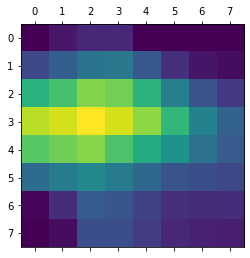

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((8, 8))
plt.matshow(heatmap)
plt.show()

In [ ]:
img = cv2.imread(ORIGINAL)


In [ ]:
INTENSITY = 0.5

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

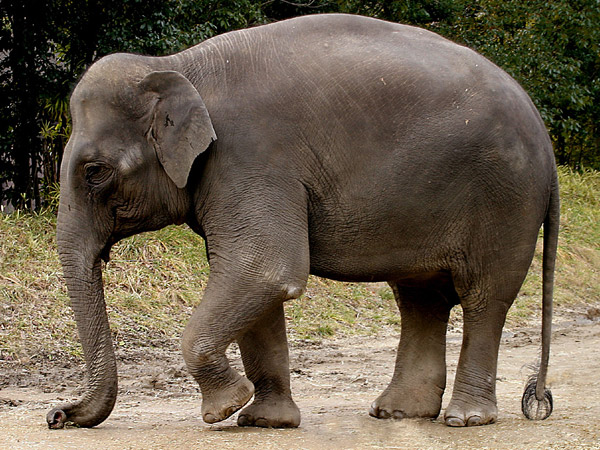

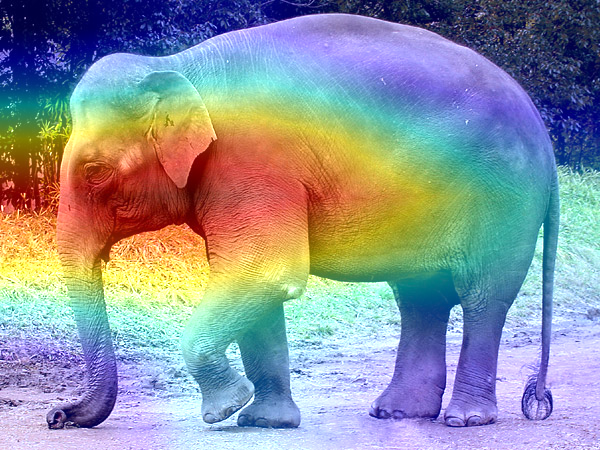

In [ ]:
cv2_imshow(cv2.imread(ORIGINAL))
cv2_imshow(img)

Labrador_retriever


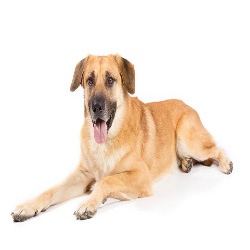

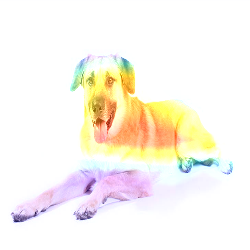

tabby


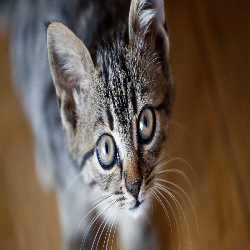

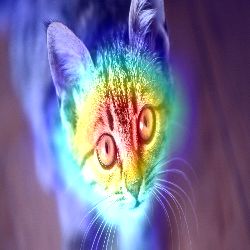

In [ ]:
def gradCAM(orig, intensity=0.5, res=250):
  img = image.load_img(orig, target_size=(DIM, DIM))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  img = cv2.imread(orig)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

  img = heatmap * intensity + img

  cv2_imshow(cv2.resize(cv2.imread(orig), (res, res)))
  cv2_imshow(cv2.resize(img, (res, res)))

gradCAM("Chinook-On-White-03.jpg")
gradCAM("Thinking-of-getting-a-cat.png")